# COGS 108 - Final Project (Individual)

# Overview

In this project, I analyzed yelp data for San Diego parks and SANDAG estimates for population ethnicity to identify if there's a correlation in favorability by park goers and population ethnicities. I grouped the parks by zip codes and determined the ethnicity percentage of each zip code to visualize the difference in ethnicity proportions. In the end, I found that there is evidence to conclude that zip codes with higher percentage of white people had higher yelp ratings. 

# Name & GitHub ID¶


- Name: Victor Montano
- GitHub Username: victormmontano

# Research Question

Does the proportion of white people in the area correlate to the favorability of parks and recreation facilities in San Diego?

# Background & Prior Work

Every city in San Diego receives different amount of funding for creation and improvement of their parks based off of their city's budget as well as development impact fees, which are fees collected from the developers who build amenities (1 & 2). The city's overall budget depends on population size, where a higher population leads to more funding (5). This year, San Diego allocated 122.2 million dollars (8%) of its budget towards parks and recreation(3 & 4). The mayor of each city submits a budget proposal to the county and then decides how much to allocate for parks and recreation (6). The development impact fees are an addition to their budget. The fee in each city varies depending on development they expect and how much money they believe will be needed for future improvements (7). Representatives and citizens from low income neighborhoods have felt like there is a lack of equity because funds are not distributed according to each city's needs (8). Furthermore, analysts have found that there is a racial equity gap in San Diego resulting in less funding going to cities with less racial diversity (9). This can be tied to the disproportionate amount of non-white business owners, particularly within construction firms (10). If the data implies that there is a systemic lack of equity throughout the county, then the city needs to allocate more funds for parks that do not have the funds to address maintenance issues and create a new system where each city receives funding according to population to ensure all parks are kept clean and accessible.


References (include links):
- 1) https://www.sdparks.org/content/sdparks/en/AboutUs/Plans/pldo.html
- 2) https://www.sdparks.org/content/dam/sdparks/en/pdf/Development/Park%20Lands%20Dedication%20Ordinance.pdf
- 3) https://www.ppic.org/publication/the-state-city-fiscal-relationship-in-california/
- 4) https://www.sandiego.gov/sites/default/files/legacy/iba/pdf/bpguide.pdf
- 5) https://econofact.org/why-does-the-census-matter-for-state-and-local-governments
- 6) https://www.sandiego.gov/sites/default/files/legacy/iba/pdf/bpguide.pdf
- 7) https://www.sandiego.gov/sites/default/files/dsd_pc-20-018_cchs_and_mcp.pdf
- 8) https://www.voiceofsandiego.org/topics/government/if-your-local-park-sucks-this-is-probably-why/
- 9) https://workforce.org/news/san-diegos-racial-equity-gap-how-we-got-here/
- 10) https://www.sandiego.gov/sites/default/files/2017-sdusd-construction-demographics-report.pdf

# Hypothesis

I hypothesize that neighborhoods with a higher proportion of white people will have higher park and recreation favorability because of the racial equity gap found in San Diego. Additionally, it is well known that implicit biases can influence business decisions and since the majority of construction firms are owned and managed by white people, it can be safe to assume that there is less development in areas with a lower amount of white people.

# Datasets

- Dataset Name: Estimate 2019 Zip
- Link to the dataset: https://github.com/victormmontano/individual_fa20/blob/master/final_project/estimate_2019_zip.xlsx
- Number of observations: 9041

The Estimate Zip dataset is from the San Diego Association of Governments (SANDAG) providing  estimates about ethnicities within the different zip code areas in San Diego over the past 10 years.

- Dataset Name: yelp SD parks
- Link to the dataset: https://github.com/victormmontano/individual_fa20/blob/master/final_project/yelp_SD_parks.csv
- Number of observations: 834

The yelp SD parks dataset is from Yelp, curated by Professor Ellis, with yelp information of parks and recreational faciliaties in San Diego including rating and location.

I plan on combining both datasets by taking the average rating of each zip code from the yelp SD parks data and the proportion of ethnicities from the Estimate Zip data in the most recent year.

# Setup

In [40]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm

# Data Cleaning

For the yelp dataset, I filtered out the reviews of a city as a whole and reviews from Mexico. For both datasets, I extracted the zip code from the address. For the data that did not contain a zip code, I either them through a Google Maps search. The estimates 2019 dataset contained the ethnicities individually so I extracted their amounts and total population to make proportion columns for easier readability and analysis. The data is very clean since the values needed have finite categories and identifiable quantity ranges because yelp ratings are between 0 and 5 and the zip codes do not go out of the normal San Diego range. 

# Data Anaylsis & Results

The yelp data is being read and stored

In [3]:
yelpInfo = pd.read_csv("yelp_SD_parks.csv")
yelpInfo

The code below filters the reviews that are for cities as a whole 

In [ ]:
infoNames = list(yelpInfo['name'])
cities = []
for i in range(len(infoNames)):
    city = infoNames[i].lower()
    if('city of' in city):
        cities.append(i)
for i in cities:
    yelpInfo = yelpInfo.drop(i)

The code below removes the unnecessary information for this analysis to make the data frames more readable

In [6]:
yelpInfo = yelpInfo.drop(columns=['phone', 'id', 'url', 'longitude', 'latitude', 'is_closed'])
yelpInfo = yelpInfo.reset_index(drop = True)
yelpInfo

,name,address,rating,review_count
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0,2105
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",4.5,46
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",4.5,242
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",4.5,102
4,Bay View Park,"413 1st St Coronado, CA 92118",5.0,42
...,...,...,...,...
828,Del Cerro - San Diego,"San Diego, CA 92120",4.5,12
829,San Diego Metropolitan Transit System,"1255 Imperial Ave Ste 1000 San Diego, CA 92101",2.5,268
830,Petco Park,"100 Park Blvd San Diego, CA 92101",4.0,1667
831,Ann D. L'Heureux Memorial Dog Park,"2700 Carlsbad Village Dr Carlsbad, CA 92008",3.0,50


The following function will extract zip codes from the addresses column

In [7]:
def extract_zip(address):
    i = address.index('CA', len(address)-8)
    return address[i+3:]

Here the zip codes are being determined and printing out the addresses that do not contain a zip code to determine whether it should be ommitted or if the zip code can be found online

In [9]:
infoAddress = list(yelpInfo['address']) 
zipCodes = []
for address in infoAddress:
    try:
        zipCodes.append(int(extract_zip(address)))
    except:
        print(address)
        zipCodes.append(0)

San Diego, CA
Av. Revolución S/N Col. Centro 22000 Tijuana, Baja California Mexico
San Diego, CA
Carrillo Puerto y o Tercera Col. Zona Centro 22000 Tijuana, Baja California Mexico
Carmel Valley Rd San Diego, CA


Here we find the names of the United States locations that did not include a zip code and adding it 

In [10]:
print(infoAddress.index("San Diego, CA"))
print(infoAddress.index("Carmel Valley Rd San Diego, CA"))
print(infoNames[224])
print(infoNames[744])
zipCodes[224] = 92114
zipCodes[744] = 92129

226
747
San Diego River Bike Path
California Creative Kids


I am adding the zip code data as a column for further analysis

In [11]:
yelpInfo['zip codes'] = zipCodes

The following is grouping the ratings by zip codes

In [12]:
sumZipCodes = []
sumRating = []
sumCount  = []
for i in range(len(yelpInfo)):
    tZipCode = yelpInfo.loc[i]['zip codes']
    tRating = yelpInfo.loc[i]['rating']
    tCount = yelpInfo.loc[i]['review_count']
    if(tZipCode not in sumZipCodes):
        sumZipCodes.append(tZipCode)
        sumRating.append(tRating)
        sumCount.append(tCount)
    else:
        ind = sumZipCodes.index(tZipCode)
        currRating = sumRating[ind]
        currCount = sumCount[ind]
        newRating = (currRating*currCount + tRating*tCount)/(currCount + tCount)
        sumRating[ind] = newRating
        sumCount[ind] = currCount + tCount

The remaining data that does not include a zip code is filtered below

In [13]:
zeroIndex = sumZipCodes.index(0)
del sumZipCodes[zeroIndex]
del sumRating[zeroIndex]
del sumCount[zeroIndex]

I am putting all the newly organized data together into a data frame

In [14]:
finalYelpRating = pd.DataFrame(list(zip(sumZipCodes, sumRating, sumCount)), 
               columns =['zip code', 'rating', 'count']) 

In [15]:
finalYelpRating

,zip code,rating,count
0,92101,4.064984,50312
1,92108,3.495904,3540
2,92116,4.234287,6189
3,92118,4.377688,1488
4,92123,3.495726,702
...,...,...,...
100,92019,4.500000,47
101,91765,4.500000,137
102,92004,5.000000,3
103,91763,5.000000,1


Here is a quick look at the data. Outliers are not being considered at the moment because they can be correlated to ethnicity differences

In [16]:
finalYelpRating.describe()

,zip code,rating,count
count,105.000000,105.000000,105.000000
mean,92039.771429,4.011991,1596.180952
std,383.201425,0.676848,5662.794556
min,90069.000000,1.000000,1.000000
25%,92014.000000,3.686957,26.000000
50%,92083.000000,4.057143,174.000000
75%,92126.000000,4.441964,628.000000
max,92879.000000,5.000000,50312.000000


The estimate data is read and stored:

In [17]:
ethnicityData = pd.read_excel("estimate_2019_zip.xlsx", "Ethnicity")

The data is filtered to only include the most recent year, 2019:

In [18]:
ethnicity2019 = ethnicityData[ethnicityData['YEAR'] == 2019]

The data is being filtered below to group by zip codes and calculate the total population of each zip code:

In [19]:
zip2019 = []
totalPop = []
list2019 = list(ethnicity2019['ZIP'])
listPop = list(ethnicity2019['POPULATION'])
for i in range(len(list2019)):
    zc = list2019[i]
    pop = listPop[i]
    if(zc not in zip2019):
        zip2019.append(zc)
        totalPop.append(pop)
    else:
        ind = zip2019.index(zc)
        currPop = totalPop[ind]
        totalPop[ind] = currPop + pop



The data is being duplicated according to the different number of ethnicities to easily add to the existing data frame

In [22]:
matchPop = []
for i in totalPop:
    for j in range(8):
        matchPop.append(i)
ethnicity2019['Zip Code Population'] = matchPop
ethnicity2019.reset_index(inplace=True, drop=True)
ethnicity2019

,ZIP,YEAR,ETHNICITY,POPULATION,Zip Code Population
0,91901,2019,American Indian,159,17873
1,91901,2019,Asian,711,17873
2,91901,2019,Black,266,17873
3,91901,2019,Hispanic,2947,17873
4,91901,2019,Other,40,17873
...,...,...,...,...,...
899,92672,2019,Hispanic,1465,4634
900,92672,2019,Other,8,4634
901,92672,2019,Pacific Islander,21,4634
902,92672,2019,Two or More,179,4634


The yelp ratings from the previous set are added that exist within this dataset

In [25]:
perc = []
addRating = []
addCount = []
for i in range(len(ethnicity2019)):
    row = ethnicity2019.loc[i]
    x = row['POPULATION']
    n = row['Zip Code Population']
    zc = row['ZIP']
    if(zc in sumZipCodes):
        ind = sumZipCodes.index(zc)
        addRating.append(sumRating[ind])
        addCount.append(sumCount[ind])
    else:
        addRating.append(0)
        addCount.append(0)
    perc.append(x/n)
ethnicity2019['ETHNICITY PERCENTAGE'] = perc
ethnicity2019['YELP RATING'] = addRating
ethnicity2019['YELP COUNT'] = addCount
yelpEthnicity = ethnicity2019[ethnicity2019['YELP RATING'] != 0]
yelpEthnicity = yelpEthnicity.reset_index(drop=True)
yelpEthnicity.head()

The ethnicity proportions are calculated:

In [26]:
ethnis = list(yelpEthnicity['ZIP'].unique())
white = []
black = []
AIAN = []
asian = []
NHOPI = []
hispanic = []
other = []
multiple = []
nonWhite = []
for i in ethnis:
    d = yelpEthnicity.loc[yelpEthnicity['ZIP'] == i]
    d.reset_index(inplace = True)
    percWhite = d['ETHNICITY PERCENTAGE'][7]
    percBlack = d['ETHNICITY PERCENTAGE'][2]
    percAIAN = d['ETHNICITY PERCENTAGE'][0]
    percAsian = d['ETHNICITY PERCENTAGE'][1]
    percHispanic = d['ETHNICITY PERCENTAGE'][3]
    percNHOPI = d['ETHNICITY PERCENTAGE'][5]
    percOther = d['ETHNICITY PERCENTAGE'][4]
    percMultiple = d['ETHNICITY PERCENTAGE'][6]
    percNonWhite = 1-percWhite
    white.append(percWhite)
    black.append(percBlack)
    AIAN.append(percAIAN)
    asian.append(percAsian)
    NHOPI.append(percNHOPI)
    hispanic.append(percHispanic)
    multiple.append(percMultiple)
    other.append(percOther)
    nonWhite.append(percNonWhite)

The proportions and yelp and estimates data frames are combined into a new data frame:

In [27]:
a = list(yelpEthnicity['ZIP'])
b = list(yelpEthnicity['Zip Code Population'])
c = list(yelpEthnicity['YELP RATING'])
d = list(yelpEthnicity['YELP COUNT'])
newZip = []
newPop = []
newRatings = []
newCount = []
for i in range(len(yelpEthnicity)):
    if(a[i] not in newZip):
        newZip.append(a[i])
        newPop.append(b[i])
        newRatings.append(c[i])
        newCount.append(d[i])
dfYelp = pd.DataFrame(list(zip(newZip, newPop, newRatings, newCount, white, black, hispanic, asian, AIAN, NHOPI, other, multiple, nonWhite)), 
               columns =['Zip', 'Population', 'Rating', 'Count', 'White', 'Black', 'Hispanic', 'Asian', 'AIAN', 'NHOPI', 'Other', 'Multiple', 'NonWhite']) 

Here we can take a glimpse at the possibility of my hypothesis being correct

In [28]:
dfYelp.groupby('White').sum().sort_values(by='White')

,Zip,Population,Rating,Count,Black,Hispanic,Asian,AIAN,NHOPI,Other,Multiple,NonWhite
White,,,,,,,,,,,,
0.041561,92173,27261,3.160920,174,0.010638,0.902865,0.023990,0.003228,0.003265,0.000514,0.013939,0.958439
0.096080,92113,48730,4.418269,208,0.114283,0.714447,0.043977,0.004186,0.003755,0.001354,0.021917,0.903920
0.104021,91950,58623,3.692308,26,0.042475,0.615697,0.201354,0.004810,0.004435,0.001416,0.025792,0.895979
0.106053,92114,58084,3.924242,33,0.199883,0.414434,0.232043,0.006353,0.005096,0.002428,0.033710,0.893947
0.135459,92154,79574,4.076138,637,0.063111,0.641340,0.125606,0.004700,0.004185,0.002626,0.022972,0.864541
...,...,...,...,...,...,...,...,...,...,...,...,...
0.737697,92036,4369,4.000000,26,0.014878,0.183566,0.017624,0.017166,0.004120,0.002747,0.022202,0.262303
0.739041,92024,56641,4.670374,989,0.009463,0.158825,0.055260,0.006762,0.003478,0.002419,0.024752,0.260959
0.744834,92118,17953,4.377688,1488,0.016989,0.153401,0.048293,0.006127,0.004233,0.002618,0.023506,0.255166


The following plots show the possible connections the proportion of each ethnicity has with yelp rating

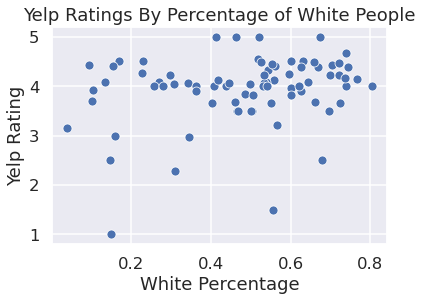

In [30]:
whiteFig = sns.scatterplot(x='White', y='Rating', data=dfYelp)
whiteFig.set(xlabel='White Percentage', ylabel='Yelp Rating', title='Yelp Ratings By Percentage of White People')
plt.show()

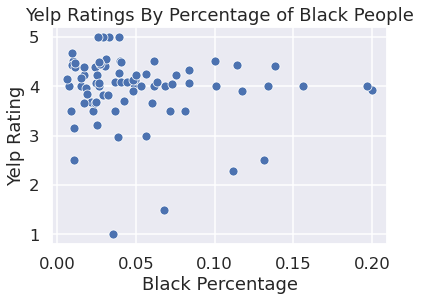

In [31]:
blackFig = sns.scatterplot(x='Black', y='Rating', data=dfYelp)
blackFig.set(xlabel='Black Percentage', ylabel='Yelp Rating', title='Yelp Ratings By Percentage of Black People')
plt.show()

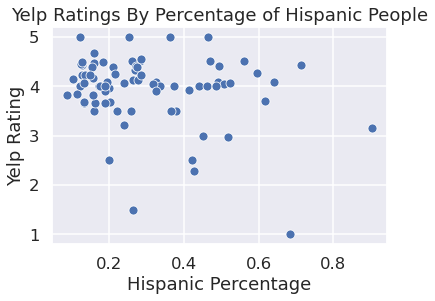

In [32]:
hispanicFig = sns.scatterplot(x='Hispanic', y='Rating', data=dfYelp)
hispanicFig.set(xlabel='Hispanic Percentage', ylabel='Yelp Rating', title='Yelp Ratings By Percentage of Hispanic People')
plt.show()

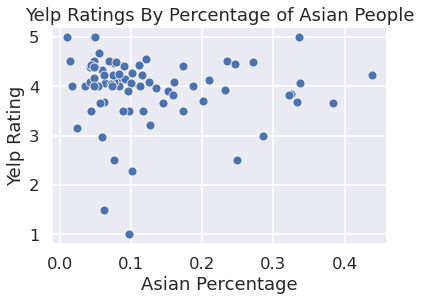

In [33]:
AsianFig = sns.scatterplot(x='Asian', y='Rating', data=dfYelp)
AsianFig.set(xlabel='Asian Percentage', ylabel='Yelp Rating', title='Yelp Ratings By Percentage of Asian People')
plt.show()

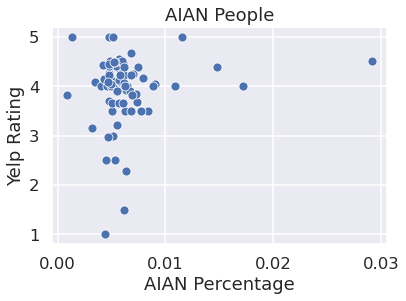

In [34]:
AIANFig = sns.scatterplot(x='AIAN', y='Rating', data=dfYelp)
AIANFig.set(xlabel='AIAN Percentage', ylabel='Yelp Rating', title='AIAN People')
plt.show()

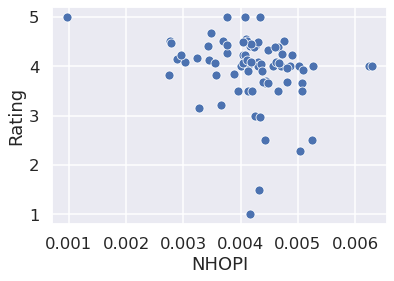

In [35]:
NHOPIFig = sns.scatterplot(x='NHOPI', y='Rating', data=dfYelp)
whiteFig.set(xlabel='NHOPI Percentage', ylabel='Yelp Rating', title='Yelp Ratings By Percentage of NHOPI People')
plt.show()

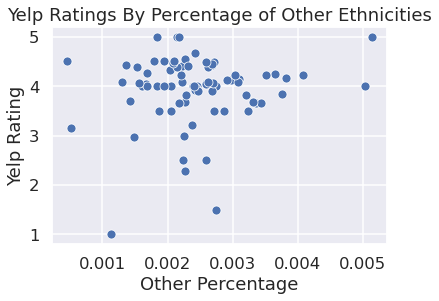

In [36]:
otherFig = sns.scatterplot(x='Other', y='Rating', data=dfYelp)
otherFig.set(xlabel='Other Percentage', ylabel='Yelp Rating', title='Yelp Ratings By Percentage of Other Ethnicities')
plt.show()

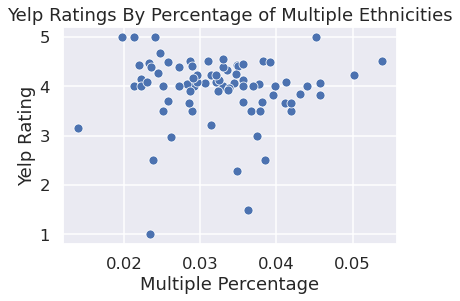

In [37]:
multipleFig = sns.scatterplot(x='Multiple', y='Rating', data=dfYelp)
multipleFig.set(xlabel='Multiple Percentage', ylabel='Yelp Rating', title='Yelp Ratings By Percentage of Multiple Ethnicities')
plt.show()

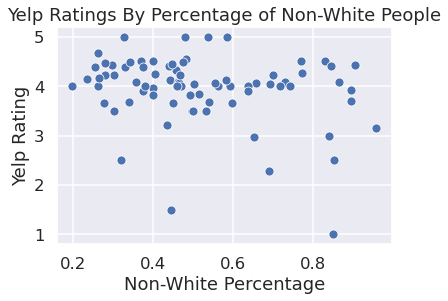

In [38]:
nonWhiteFig = sns.scatterplot(x='NonWhite', y='Rating', data=dfYelp)
nonWhiteFig.set(xlabel='Non-White Percentage', ylabel='Yelp Rating', title='Yelp Ratings By Percentage of Non-White People')
plt.show()

From the scatterplots, it is easy to see that higher proportion of white people have higher yelp ratings

In [42]:
outcome_1, predictors_1 = patsy.dmatrices('Rating~White',dfYelp)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [43]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.988
Date:                Wed, 16 Dec 2020   Prob (F-statistic):             0.0285
Time:                        23:59:10   Log-Likelihood:                -78.303
No. Observations:                  78   AIC:                             160.6
Df Residuals:                      76   BIC:                             165.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5199      0.204     17.227      0.0

Using ordinary least squares regression and a significane value of 0.025, the data provides sufficient evidence to argue that the proportion of white people correlates to the favorability of parks and recreational facilities in San Diego

In [44]:
outcome, predictors = patsy.dmatrices('Rating~White + NonWhite', dfYelp)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.988
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0285
Time:                        00:00:32   Log-Likelihood:                -78.303
No. Observations:                  78   AIC:                             160.6
Df Residuals:                      76   BIC:                             165.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6399      0.051     52.044      0.0

This double regression with white and non-white people shows that white proportions have a higher impact than non-white proportions for yelp ratings

# Ethics & Privacy¶


The datasets used are from publically accessible sources with no personally identifiable information. The Yelp data does not include any personal reviews, therefore an individual user cannot be pinpoited, however, they can be seen within the revieweres for the respective parks and recreational facilities in San Diego. This is not a significant privacy issue because Yelp users are aware that they make their data public upon reviewing. The Yelp data is potentially biased because not everyone makes Yelp reviews when visiting a park, so there is the technology and language barrier in the use of the website. Additionally, people who tend to have polarizing opinions tend to submit reviews whereas those who are neutral do not. With all this in mind, it is important to note that this analysis is not entirely representative of the San Diego population and receiving opinions from the people first hand should be the most important factor for any government decision.

# Conclusion & Discussion

This analysis contains data from yelp reviews to get a quantitative value for the favorability of parks and recreational facilities in each San Diego zip code with population ethnicities considered. From this data and analysis, there was sufficient evidence to claim that the proportion of white people in an area correlates to the favorability of parks and recreation facilities in San Diego. This reinforces the findings from other analysts that show that there is a racial equity gap in San Diego and encourages government leaders to invest more into diverse communities.